In [1]:
import pandas as pd
import numpy as np
import pickle
import missingno as msno
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alsukurmakaeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_excel('logs.xlsx')

In [3]:
df.head(10)

,id,create_date,log
0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,Unable to get integration token
1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,Unable to get integration token
2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,Unable to get integration token
3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,Unable to get integration token
4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,Pp3.Contracts.Dto.Contract.Action.ContractActi...
5,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,Unable to process OnFlushDirty interceptors
6,adcef5d317057946bac2ee0a390874d1,2023-10-09 00:00:09,Ошибка обработки запроса на регистрацию/измене...
7,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,System.InvalidOperationException: У прямой зак...
8,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,"Execution error, job: Granit.Cssp.Jobs.Purchas..."
9,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:09,Pp3.Contracts.Dto.Contract.Action.ContractActi...


# Data preporation

### Количество уникальных логов

In [4]:
df.log.nunique()

50393

### Количество слов в логах

In [5]:
df['len_logs'] = df['log'].apply(lambda x: len(x.split(' ')))

In [6]:
df.head()

,id,create_date,log,len_logs
0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,Unable to get integration token,5
1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,Unable to get integration token,5
2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,Unable to get integration token,5
3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,Unable to get integration token,5
4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,Pp3.Contracts.Dto.Contract.Action.ContractActi...,7


In [7]:
df.len_logs.nunique()

123

### Наличие пропусков

<AxesSubplot: >

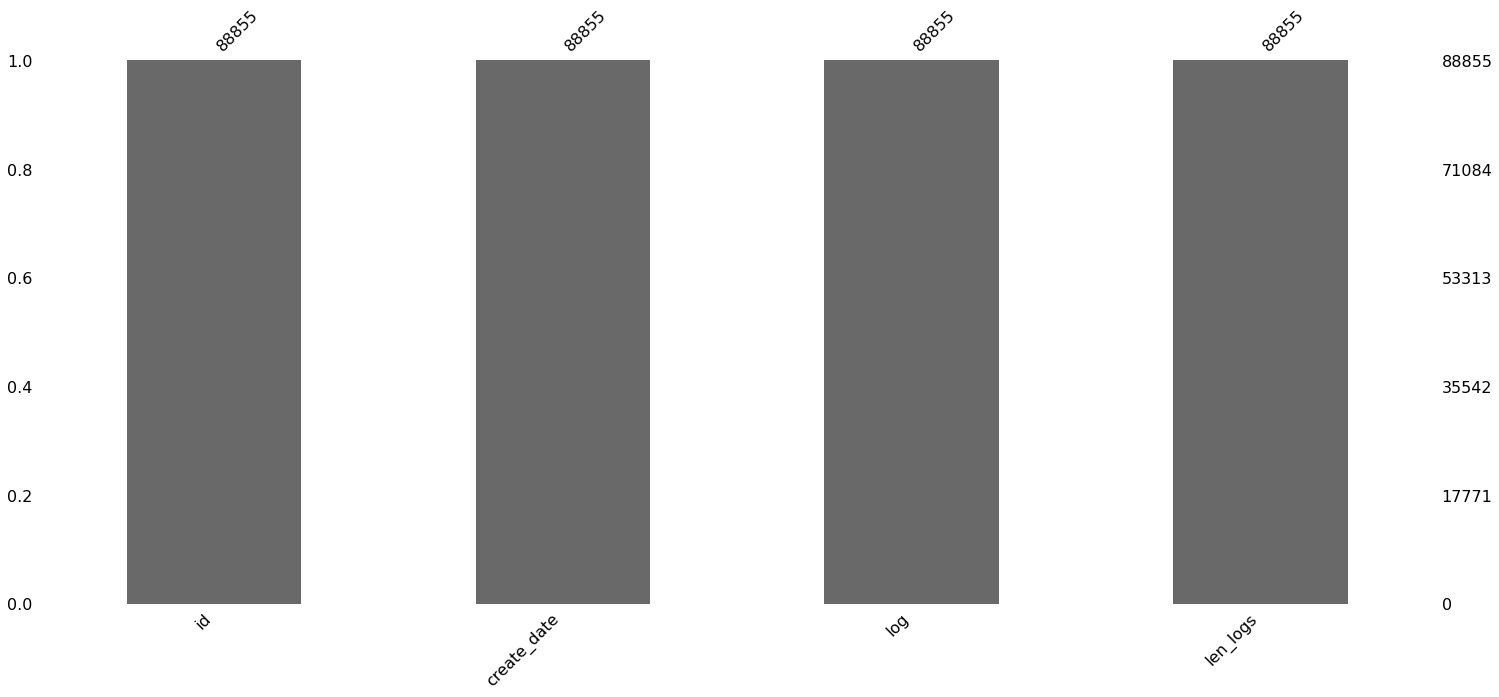

In [8]:
msno.bar(df)

### Обработка логов

Проделаны следующие шаги:
- удалены ссылки
- текст приведен к нижнему регистру
- удалены лишние пробелы
- удалены неинформативные слова (стоп слова)

In [9]:
data = df

In [10]:
def text_without_url(text):
    return re.sub(r'http\S+', '', text)

def text_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    res = re.sub(r'[^\w\s]', ' ', text)
    return res

def remove_whitespace(text):
    return  " ".join(text.split())

eng_stop_words = set(stopwords.words('english') + stopwords.words('russian'))
def remove_stopwords(text):
    stop_words = eng_stop_words
    filtered_text = [word for word in text.split(' ') if word not in stop_words] #after emogi
    return " ".join(filtered_text)


In [11]:
data['log'] = data['log'].apply(lambda x: text_without_url(x))
data['log'] = data['log'].apply(lambda x: text_lowercase(x))
data['log'] = data['log'].apply(lambda x: remove_punctuation(x))
data['log'] = data['log'].apply(lambda x: remove_whitespace(x))
data['log'] = data['log'].apply(lambda x: remove_stopwords(x))

In [12]:
data.head(10)

,id,create_date,log,len_logs
0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,unable get integration token,5
1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,unable get integration token,5
2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,unable get integration token,5
3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,unable get integration token,5
4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,pp3 contracts dto contract action contractacti...,7
5,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,unable process onflushdirty interceptors,5
6,adcef5d317057946bac2ee0a390874d1,2023-10-09 00:00:09,ошибка обработки запроса регистрацию изменение...,11
7,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,system invalidoperationexception прямой закуки...,129
8,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,execution error job granit cssp jobs purchaser...,8
9,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:09,pp3 contracts dto contract action contractacti...,7


# TF-IDF

In [13]:
random_state=42

In [14]:
vec = TfidfVectorizer()
vec.fit(data.log.values)

TfidfVectorizer()

In [15]:
with open('tfidf.pickle', 'wb') as f:
    pickle.dump(vec, f)

In [16]:
# with open('tfidf.pickle', 'rb') as f:
#     tfidf = pickle.load(f)

In [17]:
features = vec.transform(data.log.values)

In [18]:
features

<88855x63962 sparse matrix of type '<class 'numpy.float64'>'
	with 1618047 stored elements in Compressed Sparse Row format>

# Clasterisation

Посмотрим какое количество кластеров будет оптимальных для разбиения

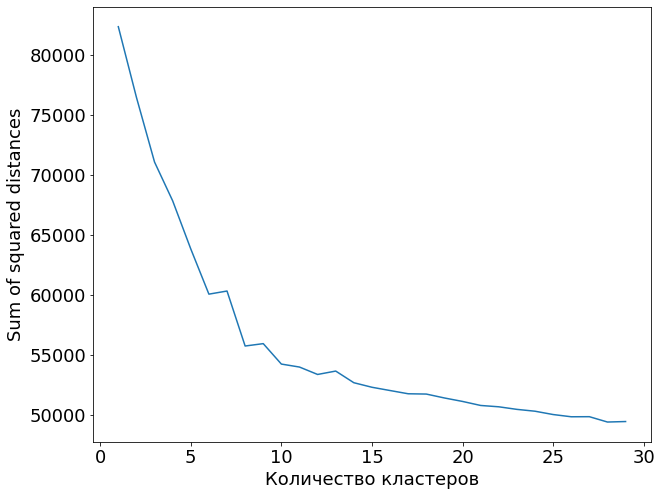

In [54]:
kmeans_results = []
distances_sums = []
MAX_K = 30
k_values = list(range(1, MAX_K))

for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features)
    kmeans_results.append(kmeans.labels_)
    # Sum of squared distances of samples to their closest cluster center.     
    distances_sums.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 18})
plt.plot(k_values, distances_sums)
plt.xlabel("Количество кластеров")
plt.ylabel("Sum of squared distances")
plt.show()

Судя по графику оптимальное количество классов для разбиения 8-15, при визульном анализе можно также выявить 8 классов. 
Оставим 8

In [21]:
cls = MiniBatchKMeans(n_clusters=8, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(random_state=42)

In [19]:
# with open('kmeans.pickle', 'rb') as f:
#     cls = pickle.load(f)

In [20]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([3, 3, 3, ..., 2, 4, 5], dtype=int32)

In [21]:
data['type'] = cls.labels_

In [22]:
print('1 type', len(data[data['type'] == 1]))
print('2 type', len(data[data['type'] == 2]))
print('3 type', len(data[data['type'] == 3]))
print('4 type', len(data[data['type'] == 4]))
print('5 type', len(data[data['type'] == 5]))
print('6 type', len(data[data['type'] == 6]))
print('7 type', len(data[data['type'] == 7]))
print('8 type', len(data[data['type'] == 0]))

1 type 5031
2 type 3458
3 type 2170
4 type 6403
5 type 19446
6 type 1346
7 type 5033
8 type 45968


Посмотрим на новости каждого типа

## 1 class

In [38]:
data[data['type'] == 1]

,id,create_date,log,len_logs,type
260,231c79e539fd4e44b3ef7058b6c5b634,2023-10-09 00:31:06,wait operation timed,5,1
267,1e572b674f576143ad2d6fde97f9b54f,2023-10-09 00:31:08,wait operation timed,5,1
271,e80967cf551b9d4d9389ce93c554231a,2023-10-09 00:31:10,wait operation timed,5,1
276,e80967cf551b9d4d9389ce93c554231a,2023-10-09 00:31:11,wait operation timed,5,1
284,e80967cf551b9d4d9389ce93c554231a,2023-10-09 00:31:26,wait operation timed,5,1
...,...,...,...,...,...
88093,ce7ddad61acabd42b51076a6c6996ea3,2023-10-16 09:01:10,wait operation timed,5,1
88397,d8471e9278e41f4982286868f82ed0c2,2023-10-16 11:01:15,wait operation timed,5,1
88549,ca2b3893caff4843b7dc1b82a2cc3e79,2023-10-16 12:01:02,wait operation timed,5,1
88553,aace3e6275c1734bb229bc6c5634a4e9,2023-10-16 12:01:02,wait operation timed,5,1


In [70]:
data[data['type'] == 1].log.nunique()

1

In [74]:
df.log[260]

'The wait operation timed out'

таймаут - операция выполняется слишком долго

## 2 class

In [39]:
data[data['type'] == 2]

,id,create_date,log,len_logs,type
4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,pp3 contracts dto contract action contractacti...,7,2
9,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:09,pp3 contracts dto contract action contractacti...,7,2
13,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:12,pp3 contracts dto contract action contractacti...,7,2
16,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:13,pp3 contracts dto contract action contractacti...,7,2
17,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:14,pp3 contracts dto contract action contractacti...,7,2
...,...,...,...,...,...
88845,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:02,pp3 contracts dto contract action contractacti...,7,2
88846,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:03,pp3 contracts dto contract action contractacti...,7,2
88848,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:04,pp3 contracts dto contract action contractacti...,7,2
88849,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:05,pp3 contracts dto contract action contractacti...,7,2


In [76]:
data[data['type'] == 2].log.nunique()

1

In [77]:
df.log[4]

'Pp3.Contracts.Dto.Contract.Action.ContractActionException: Действие по автоматическому отказу не разрешено'

Действие по автоматическому отказу не разрешено

## 3 class

In [40]:
data[data['type'] == 3]

,id,create_date,log,len_logs,type
0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,unable get integration token,5,3
1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,unable get integration token,5,3
2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,unable get integration token,5,3
3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,unable get integration token,5,3
14,5d53335d07db2fa6f4cb6ce647efa775,2023-10-09 00:00:12,unable get integration token,5,3
...,...,...,...,...,...
69279,e7b53f8391a5212ce751ca4947a65682,2023-10-15 18:00:02,unable get data,4,3
88208,00b0475ee8b9a9f47c80d902f93f2faf,2023-10-16 10:00:07,unable get data,4,3
88392,192fbec26b4a90976d1e8fc95f642b08,2023-10-16 11:00:32,unable get data,4,3
88528,46a4424039fd6f04cd51fb3b63d385ce,2023-10-16 12:00:01,unable get data,4,3


In [80]:
data[data['type'] == 3].log.nunique()

2

In [81]:
df.log[3]

'Unable to get integration token'

In [82]:
df.log[69279]

'Unable to get data'

Невозможно получить данные

## 4 class

In [41]:
data[data['type'] == 4]

,id,create_date,log,len_logs,type
6,adcef5d317057946bac2ee0a390874d1,2023-10-09 00:00:09,ошибка обработки запроса регистрацию изменение...,11,4
10,adcef5d317057946bac2ee0a390874d1,2023-10-09 00:00:09,ошибка обработки запроса регистрацию изменение...,11,4
11,adcef5d317057946bac2ee0a390874d1,2023-10-09 00:00:09,ошибка обработки запроса регистрацию изменение...,11,4
12,c8b405f9b3b53640b68f86bb1d295410,2023-10-09 00:00:12,ошибка обработки запроса регистрацию изменение...,11,4
77,553101c6ca859148a8ba51c6a0ab94bf,2023-10-09 00:05:06,ошибка обработки запроса регистрацию изменение...,11,4
...,...,...,...,...,...
88839,0b0bf7700795ea4c954040bcfd756a38,2023-10-16 13:25:05,ошибка обработки запроса регистрацию изменение...,11,4
88847,7c15735089bacd4bacf44b07f4d2969a,2023-10-16 13:30:03,ошибка обработки запроса регистрацию изменение...,11,4
88850,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4
88851,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4


In [84]:
data[data['type'] == 4].log.nunique()

4

In [85]:
data[data['type'] == 4].log.unique()

array(['ошибка обработки запроса регистрацию изменение данных компании id 23264576 type customer',
       'ошибка обработки запроса регистрацию изменение данных компании id 23285587 type customer',
       'ошибка обработки запроса регистрацию изменение данных компании id 23300770 type customer',
       'ошибка обработки запроса регистрацию изменение данных компании id 21236398 type customer'],
      dtype=object)

In [86]:
df.log[88851]

"Ошибка обработки запроса на регистрацию/изменение данных компании id: 23285587 type: 'Customer'"

ошибка обработки запроса на регистрацию/изменение данных компании

## 6 class

In [43]:
data[data['type'] == 6]

,id,create_date,log,len_logs,type
4978,3268829f31dc04a742f9467659385063,2023-10-09 09:34:26,unexpected error occured,3,6
5008,381c11ba1d65f5897f246feb7e7affd1,2023-10-09 09:54:45,unexpected error occured,3,6
5191,7d1f8c99569eeda565202f95e14b2a50,2023-10-09 11:05:42,unexpected error occured,3,6
5192,a0ec46fd15cd972af28ff683ac2c8303,2023-10-09 11:05:42,unexpected error occured,3,6
5212,85416aae921006a4f4812b2b943f15bd,2023-10-09 11:17:24,unexpected error occured,3,6
...,...,...,...,...,...
88834,5a88ad84b9b6d970473133912ab7fb45,2023-10-16 13:24:07,unexpected error occured,3,6
88835,182d6180359a3021ddddf151b584c3c5,2023-10-16 13:24:08,unexpected error occured,3,6
88841,3b02808bb1663ef9804a4ff90136069f,2023-10-16 13:25:41,unexpected error occured,3,6
88843,28c3eb484c875e78dfac333424b138f1,2023-10-16 13:28:57,unexpected error occured,3,6


In [88]:
data[data['type'] == 6].log.nunique()

1

In [89]:
df.log[4978]

'Unexpected error occured'

## 7 class

In [48]:
data[data['type'] == 7]

,id,create_date,log,len_logs,type
259,231c79e539fd4e44b3ef7058b6c5b634,2023-10-09 00:31:06,execution timeout expired timeout period elaps...,20,7
266,1e572b674f576143ad2d6fde97f9b54f,2023-10-09 00:31:08,execution timeout expired timeout period elaps...,20,7
270,e80967cf551b9d4d9389ce93c554231a,2023-10-09 00:31:10,execution timeout expired timeout period elaps...,20,7
275,e80967cf551b9d4d9389ce93c554231a,2023-10-09 00:31:11,execution timeout expired timeout period elaps...,20,7
283,e80967cf551b9d4d9389ce93c554231a,2023-10-09 00:31:26,execution timeout expired timeout period elaps...,20,7
...,...,...,...,...,...
88092,ce7ddad61acabd42b51076a6c6996ea3,2023-10-16 09:01:10,execution timeout expired timeout period elaps...,20,7
88396,d8471e9278e41f4982286868f82ed0c2,2023-10-16 11:01:15,execution timeout expired timeout period elaps...,20,7
88548,ca2b3893caff4843b7dc1b82a2cc3e79,2023-10-16 12:01:02,execution timeout expired timeout period elaps...,20,7
88551,aace3e6275c1734bb229bc6c5634a4e9,2023-10-16 12:01:02,execution timeout expired timeout period elaps...,20,7


In [90]:
data[data['type'] == 7].log.nunique()

3

In [91]:
data[data['type'] == 7].log.unique()

array(['execution timeout expired timeout period elapsed prior completion operation server responding',
       'execution timeout expired timeout period elapsed prior completion operation server responding _x000d_ operation cancelled user _x000d_ statement terminated',
       'execution timeout expired timeout period elapsed prior completion operation server responding _x000d_ operation cancelled user'],
      dtype=object)

In [92]:
df.log[88548]

'Execution Timeout Expired.  The timeout period elapsed prior to completion of the operation or the server is not responding.'

In [93]:
df.log[270]

'Execution Timeout Expired.  The timeout period elapsed prior to completion of the operation or the server is not responding.'

До завершения операции истек период таймаута или сервер не отвечает

## operation cancelled

## 5 class

In [23]:
data[data['type'] == 5]

,id,create_date,log,len_logs,type
5,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,unable process onflushdirty interceptors,5,5
7,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,system invalidoperationexception прямой закуки...,129,5
8,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,execution error job granit cssp jobs purchaser...,8,5
48,b3b16fc1dd1dfdad41fa2ecd054ec7d0,2023-10-09 00:01:46,kaluga workflowid 6d7de862 fc5c 434f 93fc b7f6...,10,5
49,b3b16fc1dd1dfdad41fa2ecd054ec7d0,2023-10-09 00:01:49,unable verify save signature,6,5
...,...,...,...,...,...
88798,668cf9e46a6797c5a2e9b298a87962f3,2023-10-16 13:09:07,unable process command 0332a1eb 0f0f 46cd 9e27...,7,5
88803,668cf9e46a6797c5a2e9b298a87962f3,2023-10-16 13:11:04,unable verify save signature,6,5
88840,a46c445cb8d9d798d88187a8fc5c8979,2023-10-16 13:25:06,unable process command 599cf799 9c32 4196 8e4a...,7,5
88842,105608a098ede2ebc78155639622b245,2023-10-16 13:28:07,unable process command fbbb6e9e 13cc 45cd 8850...,7,5


In [24]:
data[data['type'] == 5].log.nunique()

4394

слишком много различных логов, попробуем еще визульно оценить похожи ли они

In [25]:
error_5 = list(data[data['type'] == 5].log.unique())

In [26]:
for i in range(2,10):
    print(' ')
    print(error_5[i])

 
execution error job granit cssp jobs purchaserequest requestanswerexpiredtogglejob key 07ae0e0b d2d6 4b64 865e 4cc382534059 args id 14101044
 
kaluga workflowid 6d7de862 fc5c 434f 93fc b7f69fd54704 unable get workflow documents sessionid 8d705d9e bf21 46b7 a4fd 00829e75a704
 
unable verify save signature
 
kaluga workflowid a92fd3f8 4318 4b37 a367 790f4288f2c1 unable get workflow documents sessionid 8d705d9e bf21 46b7 a4fd 00829e75a704
 
kaluga workflowid 82f94a42 e9a1 4c91 af3d 315453ceeca9 unable get workflow documents sessionid 8d705d9e bf21 46b7 a4fd 00829e75a704
 
kaluga workflowid d3e1258e 9a3b 48d6 bf07 8871a3f44472 unable get workflow documents sessionid 8d705d9e bf21 46b7 a4fd 00829e75a704
 
kaluga workflowid a59dc7bd 5238 40e2 9f82 9ad0919ecf35 unable get workflow documents sessionid 8d705d9e bf21 46b7 a4fd 00829e75a704
 
kaluga workflowid 89c21f3c f260 4b2a 899d f1c73f0b8766 unable get workflow documents sessionid 8d705d9e bf21 46b7 a4fd 00829e75a704


### Посмотрим можно ли еще поделить эти классы

In [27]:
features_5 = vec.transform(data[data['type'] == 5].log.values)

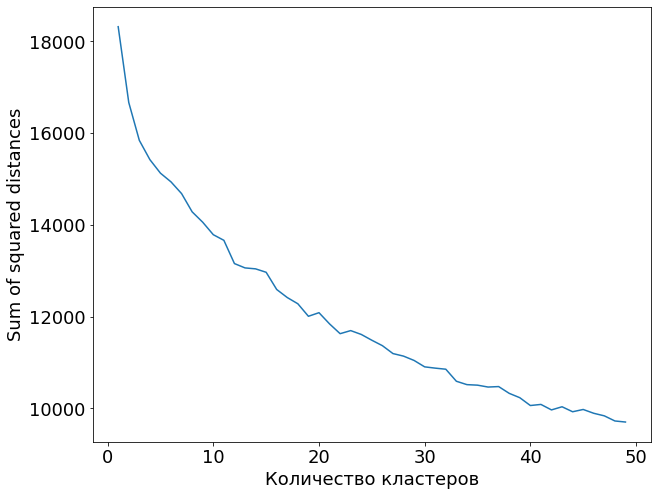

In [104]:
kmeans_results = []
distances_sums = []
MAX_K = 50
k_values = list(range(1, MAX_K))

for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features_5)
    kmeans_results.append(kmeans.labels_)
    # Sum of squared distances of samples to their closest cluster center.     
    distances_sums.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 18})
plt.plot(k_values, distances_sums)
plt.xlabel("Количество кластеров")
plt.ylabel("Sum of squared distances")
plt.show()

#### поделили еще на 10 классов

In [28]:
cls_5 = MiniBatchKMeans(n_clusters=10, random_state=random_state)
cls_5.fit(features_5)

MiniBatchKMeans(n_clusters=10, random_state=42)

In [35]:
with open('kmeans_5g.pickle', 'wb') as f:
    pickle.dump(cls_5, f)

In [29]:
# predict cluster labels for new dataset
cls_5.predict(features_5)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls_5.labels_

array([2, 2, 3, ..., 2, 2, 2], dtype=int32)

In [30]:
data['type_5'] = 0

In [31]:
data_5cl = data[data['type'] == 5]
data_5cl.reset_index(inplace=True)

In [32]:
data_5cl['type_5'] = cls_5.labels_

In [34]:
data_5cl

,index,id,create_date,log,len_logs,type,type_5
0,5,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,unable process onflushdirty interceptors,5,5,2
1,7,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,system invalidoperationexception прямой закуки...,129,5,2
2,8,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,execution error job granit cssp jobs purchaser...,8,5,3
3,48,b3b16fc1dd1dfdad41fa2ecd054ec7d0,2023-10-09 00:01:46,kaluga workflowid 6d7de862 fc5c 434f 93fc b7f6...,10,5,4
4,49,b3b16fc1dd1dfdad41fa2ecd054ec7d0,2023-10-09 00:01:49,unable verify save signature,6,5,2
...,...,...,...,...,...,...,...
19441,88798,668cf9e46a6797c5a2e9b298a87962f3,2023-10-16 13:09:07,unable process command 0332a1eb 0f0f 46cd 9e27...,7,5,2
19442,88803,668cf9e46a6797c5a2e9b298a87962f3,2023-10-16 13:11:04,unable verify save signature,6,5,2
19443,88840,a46c445cb8d9d798d88187a8fc5c8979,2023-10-16 13:25:06,unable process command 599cf799 9c32 4196 8e4a...,7,5,2
19444,88842,105608a098ede2ebc78155639622b245,2023-10-16 13:28:07,unable process command fbbb6e9e 13cc 45cd 8850...,7,5,2


In [33]:
print('0 type', len(data_5cl[data_5cl['type_5'] == 0]))
print('1 type', len(data_5cl[data_5cl['type_5'] == 1]))
print('2 type', len(data_5cl[data_5cl['type_5'] == 2]))
print('3 type', len(data_5cl[data_5cl['type_5'] == 3]))
print('4 type', len(data_5cl[data_5cl['type_5'] == 4]))
print('5 type', len(data_5cl[data_5cl['type_5'] == 5]))
print('6 type', len(data_5cl[data_5cl['type_5'] == 6]))
print('7 type', len(data_5cl[data_5cl['type_5'] == 7]))
print('8 type', len(data_5cl[data_5cl['type_5'] == 8]))
print('9 type', len(data_5cl[data_5cl['type_5'] == 9]))

0 type 338
1 type 640
2 type 4188
3 type 6717
4 type 1349
5 type 577
6 type 286
7 type 3587
8 type 841
9 type 923


In [126]:
for i in range(10):
    d = data_5cl[data_5cl['type_5'] == i]
    print(f'Class {i} count unique log = {d.log.nunique()}')

Class 0 count unique log = 1
Class 1 count unique log = 16
Class 2 count unique log = 859
Class 3 count unique log = 1803
Class 4 count unique log = 743
Class 5 count unique log = 5
Class 6 count unique log = 2
Class 7 count unique log = 94
Class 8 count unique log = 173
Class 9 count unique log = 698


In [129]:
for i in range(10):
    d = data_5cl[data_5cl['type_5'] == i]
    print(f'Class {i}')
    print(d.log.sample(5))

Class 0
1878     ошибка выполнения подписчика событие завершени...
11394    ошибка выполнения подписчика событие завершени...
17154    ошибка выполнения подписчика событие завершени...
12082    ошибка выполнения подписчика событие завершени...
9889     ошибка выполнения подписчика событие завершени...
Name: log, dtype: object
Class 1
3501     could execute query select cast count this_ id...
14167    could execute query select cast sum this_ rubs...
17076    could execute query select cast sum this_ rubs...
18758    could execute query select cast sum this_ rubs...
7076     could execute query select cast count this_ id...
Name: log, dtype: object
Class 2
14538    проверка приглашений 70768471 5ff3 4a5b 9f37 b...
700      unable process command c4905af1 cdb5 40b3 9221...
9067     could execute query exec dbo getcontractaction...
19429    unable process command 599cf799 9c32 4196 8e4a...
1858     unhandled error pp3 publicapi shared contracta...
Name: log, dtype: object
Class 3
8094    

In [132]:
data_5cl[data_5cl['type_5'] == 8]

,id,create_date,log,len_logs,type,target,type_5
1202,7cd4e04142ca9bdc8b0e5dc81f6e667c,2023-10-09 06:01:27,connection id 18014398536862455282 request id ...,14,5,0,8
1342,713b7aa10aabd6ba828cc0872c4dc397,2023-10-09 07:40:36,connection id 17005592224626426334 request id ...,14,5,0,8
1343,3f230c6dd7557ec66b9b9917947e34c0,2023-10-09 07:40:36,connection id 16573246647513940097 request id ...,14,5,0,8
1344,b7364deb0c8736e748564846f2ce4e87,2023-10-09 07:40:36,connection id 17798225754748677937 request id ...,14,5,0,8
1380,869b4e40d337f783fd980d4afcb775bf,2023-10-09 08:19:06,exception sendcommand command c2e014aa c923 43...,6,5,0,8
...,...,...,...,...,...,...,...
19363,033a6ac520d958ad6984abf1116391e4,2023-10-16 12:00:01,exception occurred processing message,5,5,0,8
19364,b9267c4a3e6bffdc4a3c1e6be061e78e,2023-10-16 12:00:01,exception occurred processing message,5,5,0,8
19398,967862be5f204042eb7a2f9df640507b,2023-10-16 12:26:15,unhandled exception action execution thrown re...,9,5,0,8
19415,442a35c9e43030c1865103bf36687291,2023-10-16 12:39:32,unhandled exception action execution thrown re...,9,5,0,8


In [134]:
data_5cl[data_5cl['type_5'] == 8].log[19398]

'unhandled exception action execution thrown reverting transaction'

In [196]:
data_5cl[data_5cl['type_5'] == 8].log[8254]

'exception sendcommand command dbe1ff58 f975 40e8 804b 18b9588f0b64 type 55493482 0ae4 4bb2 885c a7033beff131'

In [135]:
data_5cl[data_5cl['type_5'] == 8].log[1380]

'exception sendcommand command c2e014aa c923 438c 8f1a d859a7fac93d type e5cca3a7 d738 4b7c 928a 4c147db8e00b'

отбросить immidiete job - дублируют первую

- 8 класс - исключение 
- 1, 5, 7 - ошибка в исполнении sql запроса
- 3 класс - ошибка выполнения задачи, нужно смотреть на лог выше
- 2 класс -
- 4 класс -
- 6 класс -

классы 1, 5, 7 - sql

In [130]:
df.log[5352]

'Unable to send CreateAuction in external system OpId:25a2b471-0bdc-4d46-8592-3c9a2715c1de'

#### Соединим датасеты

In [62]:
data_5cl

,index_new,id,create_date,log,len_logs,type,type_5
0,5,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,unable process onflushdirty interceptors,5,5,2
1,7,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,system invalidoperationexception прямой закуки...,129,5,2
2,8,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,execution error job granit cssp jobs purchaser...,8,5,3
3,48,b3b16fc1dd1dfdad41fa2ecd054ec7d0,2023-10-09 00:01:46,kaluga workflowid 6d7de862 fc5c 434f 93fc b7f6...,10,5,4
4,49,b3b16fc1dd1dfdad41fa2ecd054ec7d0,2023-10-09 00:01:49,unable verify save signature,6,5,2
...,...,...,...,...,...,...,...
19441,88798,668cf9e46a6797c5a2e9b298a87962f3,2023-10-16 13:09:07,unable process command 0332a1eb 0f0f 46cd 9e27...,7,5,2
19442,88803,668cf9e46a6797c5a2e9b298a87962f3,2023-10-16 13:11:04,unable verify save signature,6,5,2
19443,88840,a46c445cb8d9d798d88187a8fc5c8979,2023-10-16 13:25:06,unable process command 599cf799 9c32 4196 8e4a...,7,5,2
19444,88842,105608a098ede2ebc78155639622b245,2023-10-16 13:28:07,unable process command fbbb6e9e 13cc 45cd 8850...,7,5,2


In [61]:
data_5cl = data_5cl.rename(columns={'index':'index_new'})

In [70]:
# data.drop('type_5', axis=1, inplace=True)
data['type_5'] = -1

In [57]:
# data.reset_index(inplace=True)

In [58]:
data

,index,id,create_date,log,len_logs,type,type_5
0,0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,unable get integration token,5,3,0
1,1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,unable get integration token,5,3,0
2,2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,unable get integration token,5,3,0
3,3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,unable get integration token,5,3,0
4,4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,pp3 contracts dto contract action contractacti...,7,2,0
...,...,...,...,...,...,...,...
88850,88850,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,0
88851,88851,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,0
88852,88852,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:06,pp3 contracts dto contract action contractacti...,7,2,0
88853,88853,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,0


In [71]:
for i in range(len(data_5cl.index_new)):
    ind = data_5cl.index_new[i]
    # print(ind, i)
    data['type_5'][ind] = data_5cl['type_5'][i]

In [72]:
data.head(10)

,index,id,create_date,log,len_logs,type,type_5
0,0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,unable get integration token,5,3,-1
1,1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,unable get integration token,5,3,-1
2,2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,unable get integration token,5,3,-1
3,3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,unable get integration token,5,3,-1
4,4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,pp3 contracts dto contract action contractacti...,7,2,-1
5,5,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,unable process onflushdirty interceptors,5,5,2
6,6,adcef5d317057946bac2ee0a390874d1,2023-10-09 00:00:09,ошибка обработки запроса регистрацию изменение...,11,4,-1
7,7,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,system invalidoperationexception прямой закуки...,129,5,2
8,8,c3a26e908605084180b05f77c367a8a0,2023-10-09 00:00:09,execution error job granit cssp jobs purchaser...,8,5,3
9,9,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:09,pp3 contracts dto contract action contractacti...,7,2,-1


In [73]:
data.type_5 = data.type_5.apply(lambda x: str(x)+'_5')

In [74]:
data

,index,id,create_date,log,len_logs,type,type_5
0,0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,unable get integration token,5,3,-1_5
1,1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,unable get integration token,5,3,-1_5
2,2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,unable get integration token,5,3,-1_5
3,3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,unable get integration token,5,3,-1_5
4,4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,pp3 contracts dto contract action contractacti...,7,2,-1_5
...,...,...,...,...,...,...,...
88850,88850,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,-1_5
88851,88851,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,-1_5
88852,88852,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:06,pp3 contracts dto contract action contractacti...,7,2,-1_5
88853,88853,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,-1_5


In [75]:
for i in range(len(data)):
    if data.type_5[i] == '-1_5':
        data.type_5[i] = data.type[i]

In [76]:
data

,index,id,create_date,log,len_logs,type,type_5
0,0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,unable get integration token,5,3,3
1,1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,unable get integration token,5,3,3
2,2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,unable get integration token,5,3,3
3,3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,unable get integration token,5,3,3
4,4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,pp3 contracts dto contract action contractacti...,7,2,2
...,...,...,...,...,...,...,...
88850,88850,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,4
88851,88851,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,4
88852,88852,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:06,pp3 contracts dto contract action contractacti...,7,2,2
88853,88853,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,ошибка обработки запроса регистрацию изменение...,11,4,4


In [79]:
for i in range(len(data)):
    if data.type_5[i] == '1_5' or data.type_5[i] == '5_5' or data.type_5[i] == '7_5':
        data.type_5[i] = 'sql'

In [80]:
data.type_5.unique()

array([3, 2, '2_5', 4, '3_5', '4_5', 'sql', 7, 1, '9_5', '6_5', '0_5',
       '8_5', 6, 0], dtype=object)

In [82]:
data = data.rename(columns={'type_5':'target'})

In [84]:
data.to_excel('logs_result.xlsx')

## 8 class

In [97]:
data[data['type'] == 0]

,id,create_date,log,len_logs,type,target
4987,b6c723bd7322adfe9b5edb41f75d38a6,2023-10-09 09:41:32,данные могут проимпортированы причине ранее им...,22,0,0
4988,3c4fc2c8dbfe87e801c4989fe941c84d,2023-10-09 09:41:32,данные могут проимпортированы причине ранее им...,22,0,0
5230,b5b5e92073d355e7415845e0ff8b27da,2023-10-09 11:24:25,данные могут проимпортированы причине ранее им...,20,0,0
5231,509d733a909242fb0cb56be590625f02,2023-10-09 11:24:49,данные могут обработаны причине данный пакет и...,20,0,0
5232,06980def752836235feff942994cff4c,2023-10-09 11:24:49,данные могут обработаны причине данный пакет и...,20,0,0
...,...,...,...,...,...,...
88732,878ca8e6b05fea3a483a97d89d6cb013,2023-10-16 12:46:59,данные могут обработаны причине ранее импортир...,22,0,0
88738,829cf23e92fdd9c2b78f7655bf6a50be,2023-10-16 12:50:40,данные могут обработаны причине ранее импортир...,22,0,0
88739,cf885bf17efa3ceb80627eb18575352f,2023-10-16 12:50:47,данные могут обработаны причине ранее импортир...,22,0,0
88740,b88369134e7bea60b3bd0cfc91195a7a,2023-10-16 12:52:58,данные могут обработаны причине ранее импортир...,22,0,0


In [94]:
data[data['type'] == 0].log.nunique()

45966

In [95]:
data[data['type'] == 0].log.unique()

array(['данные могут проимпортированы причине ранее импортирована поздняя версия сущности packageguid 34850742 packagedatetime 09 10 2023 8 41 14 03 00',
       'данные могут проимпортированы причине ранее импортирована поздняя версия сущности packageguid 34850741 packagedatetime 09 10 2023 8 41 14 03 00',
       'данные могут проимпортированы причине ранее импортирована поздняя версия сущности packageid 34850768 packagedate 09 10 2023 11 24 24',
       ...,
       'данные могут обработаны причине ранее импортирована поздняя версия сущности packageguid 11000d0014732100 11539 packagedatetime 16 10 2023 4 59 11 00 00',
       'данные могут обработаны причине ранее импортирована поздняя версия сущности packageguid 14001900b36d3500 5671 packagedatetime 16 10 2023 5 13 08 00 00',
       'данные могут обработаны причине ранее импортирована поздняя версия сущности packageguid 0b000000d9ac2700 6464 packagedatetime 16 10 2023 5 14 00 00 00'],
      dtype=object)

In [96]:
df.log[88739]

'Данные не могут быть обработаны по причине: Ранее была импортирована более поздняя версия сущности. PackageGuid : 11000d0014732100-11539, PackageDateTime : 16.10.2023 4:59:11 +00:00'

Данные не могут быть обработаны по причине: Ранее была импортирована более поздняя версия сущности.

## End

Классы действительно хорошо разделены, сохраним модель

In [50]:
with open('kmeans.pickle', 'wb') as f:
    pickle.dump(cls, f)

In [69]:
df.log[13263]

'immediate job 2eec8d41 fd97 4fa2 aa9f e2d30a26c150 execution failed trying enqueue job'

# Группировка по времени

In [166]:
df = pd.read_excel('logs.xlsx')

In [167]:
df

,id,create_date,log
0,6424198940e01f33f8b596fa9fe7391c,2023-10-09 00:00:01,Unable to get integration token
1,9851574021c269d401accc3a1381259a,2023-10-09 00:00:02,Unable to get integration token
2,35f4f5fc4fdd12717347c2064729930e,2023-10-09 00:00:02,Unable to get integration token
3,49f9dc2cb58ab8db9f59b2487fbe0768,2023-10-09 00:00:02,Unable to get integration token
4,4f4830735dfc264fb40d1424e3e02bb2,2023-10-09 00:00:08,Pp3.Contracts.Dto.Contract.Action.ContractActi...
...,...,...,...
88850,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,Ошибка обработки запроса на регистрацию/измене...
88851,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,Ошибка обработки запроса на регистрацию/измене...
88852,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:06,Pp3.Contracts.Dto.Contract.Action.ContractActi...
88853,954c4593de12c14c8a51a08ae24f2cdf,2023-10-16 13:30:06,Ошибка обработки запроса на регистрацию/измене...


In [168]:
df['log'] = df['log'].apply(lambda x: '\n'+x+'\n')

In [169]:
df.create_date.nunique()

40450

In [170]:
df_time = df.groupby('create_date').sum()
df_time.reset_index(inplace=True)

In [171]:
df_time

,create_date,id,log
0,2023-10-09 00:00:01,6424198940e01f33f8b596fa9fe7391c,\nUnable to get integration token\n
1,2023-10-09 00:00:02,9851574021c269d401accc3a1381259a35f4f5fc4fdd12...,\nUnable to get integration token\n\nUnable to...
2,2023-10-09 00:00:08,4f4830735dfc264fb40d1424e3e02bb2,\nPp3.Contracts.Dto.Contract.Action.ContractAc...
3,2023-10-09 00:00:09,c3a26e908605084180b05f77c367a8a0adcef5d3170579...,\nUnable to process OnFlushDirty interceptors\...
4,2023-10-09 00:00:12,c8b405f9b3b53640b68f86bb1d2954104f4830735dfc26...,\nОшибка обработки запроса на регистрацию/изме...
...,...,...,...
40445,2023-10-16 13:30:03,c6a3630169618e449c4770842dfd8bcc7c15735089bacd...,\nPp3.Contracts.Dto.Contract.Action.ContractAc...
40446,2023-10-16 13:30:04,c6a3630169618e449c4770842dfd8bcc,\nPp3.Contracts.Dto.Contract.Action.ContractAc...
40447,2023-10-16 13:30:05,c6a3630169618e449c4770842dfd8bcc,\nPp3.Contracts.Dto.Contract.Action.ContractAc...
40448,2023-10-16 13:30:06,954c4593de12c14c8a51a08ae24f2cdf954c4593de12c1...,\nОшибка обработки запроса на регистрацию/изме...


In [157]:
df_time.log[40445]

" Pp3.Contracts.Dto.Contract.Action.ContractActionException: Действие по автоматическому отказу не разрешено  Ошибка обработки запроса на регистрацию/изменение данных компании id: 21236398 type: 'Customer' "

In [156]:
df[df.create_date == '2023-10-16 13:30:03']

,id,create_date,log
88846,c6a3630169618e449c4770842dfd8bcc,2023-10-16 13:30:03,Pp3.Contracts.Dto.Contract.Action.ContractAct...
88847,7c15735089bacd4bacf44b07f4d2969a,2023-10-16 13:30:03,Ошибка обработки запроса на регистрацию/измен...


In [172]:
def text_without_url(text):
    return re.sub(r'http\S+', '', text)

def text_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    res = re.sub(r'[^\w\s]', ' ', text)
    return res

def remove_whitespace(text):
    return  " ".join(text.split())

eng_stop_words = set(stopwords.words('english') + stopwords.words('russian'))
def remove_stopwords(text):
    stop_words = eng_stop_words
    filtered_text = [word for word in text.split(' ') if word not in stop_words] #after emogi
    return " ".join(filtered_text)

In [173]:
df_time['log'] = df_time['log'].apply(lambda x: text_without_url(x))
df_time['log'] = df_time['log'].apply(lambda x: text_lowercase(x))
df_time['log'] = df_time['log'].apply(lambda x: remove_punctuation(x))
df_time['log'] = df_time['log'].apply(lambda x: remove_whitespace(x))
df_time['log'] = df_time['log'].apply(lambda x: remove_stopwords(x))

In [174]:
vec = TfidfVectorizer()
vec.fit(df_time.log.values)

TfidfVectorizer()

In [175]:
features = tfidf.transform(df_time.log.values)

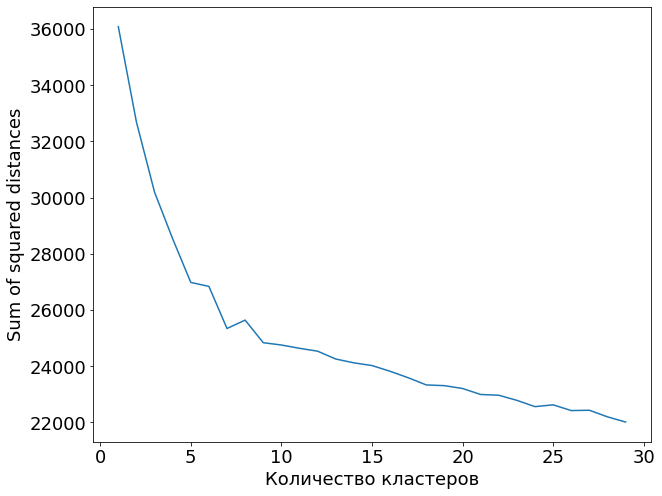

In [176]:
kmeans_results = []
distances_sums = []
MAX_K = 30
k_values = list(range(1, MAX_K))

for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features)
    kmeans_results.append(kmeans.labels_)
    # Sum of squared distances of samples to their closest cluster center.     
    distances_sums.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 18})
plt.plot(k_values, distances_sums)
plt.xlabel("Количество кластеров")
plt.ylabel("Sum of squared distances")
plt.show()

In [178]:
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_
df_time['type'] = cls.labels_

In [182]:
df_time['type'].unique()

array([1, 2, 4, 3, 0], dtype=int32)

In [183]:
for i in range(5):
    d = df_time[df_time['type'] == i]
    print(f'Class {i}')
    print(f'Class {i} count unique log = {d.log.nunique()}')
    print(f'Class {i} count log = {len(d)}')
    print()

Class 0
Class 0 count unique log = 2527
Class 0 count log = 2527

Class 1
Class 1 count unique log = 4259
Class 1 count log = 13557

Class 2
Class 2 count unique log = 94
Class 2 count log = 3150

Class 3
Class 3 count unique log = 18832
Class 3 count log = 18846

Class 4
Class 4 count unique log = 2369
Class 4 count log = 2370



In [185]:
df_time[df_time['type'] == 0]

,create_date,id,log,type
8408,2023-10-12 09:34:50,63188e8d3a0f7ab1197b30b35dba4fc9,данные могут обработаны причине данный пакет и...,0
11862,2023-10-15 00:12:52,f5f8831aa4169988892ffa89d3ecd377,данные могут проимпортированы причине ранее им...,0
11863,2023-10-15 00:13:21,7c73bb1ffac6d2201e0e6bab2249e0d5,данные могут проимпортированы причине ранее им...,0
11903,2023-10-15 00:21:18,ae463dee2c3ca29be11efe2abaf8d537,данные могут проимпортированы причине ранее им...,0
12385,2023-10-15 01:14:06,b9e95600a78bd2e7856b185a9f8b1abc,данные могут проимпортированы причине ранее им...,0
...,...,...,...,...
39694,2023-10-16 06:05:23,52d4d82edae31c1f364009084cd6a89f,данные могут обработаны причине ранее импортир...,0
39904,2023-10-16 08:13:43,254fd9d3150eddc292c9c182e3c9bb88,данные могут обработаны причине ранее импортир...,0
39947,2023-10-16 08:48:22,165b6dfb5acd2c47c414f0ac99eff64d,данные могут обработаны причине ранее импортир...,0
40116,2023-10-16 10:32:48,ab66a9f44b3022bbd3f66ce571cc6e0406aa59771b6490...,данные могут обработаны причине ранее импортир...,0


In [188]:
df_time.log[40116]

'данные могут обработаны причине ранее импортирована поздняя версия сущности packageguid 19001200c9312e00 17374 packagedatetime 16 10 2023 1 12 16 00 00 данные могут обработаны причине ранее импортирована поздняя версия сущности packageguid 2800070081951500 17430 packagedatetime 16 10 2023 1 12 16 00 00'

In [187]:
df_time.log[12385]

'данные могут проимпортированы причине ранее импортирована поздняя версия сущности packageguid 36779048 packagedatetime 15 10 2023 1 12 59 03 00'

In [189]:
df_time[df_time['type'] == 1]

,create_date,id,log,type
0,2023-10-09 00:00:01,6424198940e01f33f8b596fa9fe7391c,unable get integration token,1
1,2023-10-09 00:00:02,9851574021c269d401accc3a1381259a35f4f5fc4fdd12...,unable get integration token unable get integr...,1
3,2023-10-09 00:00:09,c3a26e908605084180b05f77c367a8a0adcef5d3170579...,unable process onflushdirty interceptors ошибк...,1
16,2023-10-09 00:00:28,4f4830735dfc264fb40d1424e3e02bb2d3f6b59fa65f31...,pp3 contracts dto contract action contractacti...,1
20,2023-10-09 00:00:44,362436dab7c4cb822dbc4e4e7a6996372349ce98e58d81...,unable get integration token unable get integr...,1
...,...,...,...,...
40441,2023-10-16 13:25:41,3b02808bb1663ef9804a4ff90136069f,unexpected error occured,1
40442,2023-10-16 13:28:07,105608a098ede2ebc78155639622b245,unable process command fbbb6e9e 13cc 45cd 8850...,1
40443,2023-10-16 13:28:57,28c3eb484c875e78dfac333424b138f12e34870cb9421a...,unexpected error occured unexpected error occured,1
40448,2023-10-16 13:30:06,954c4593de12c14c8a51a08ae24f2cdf954c4593de12c1...,ошибка обработки запроса регистрацию изменение...,1


In [ ]:
const1 = 'unable get integration token' # в один токен

In [190]:
df_time.log[1]

'unable get integration token unable get integration token unable get integration token'

In [192]:
df_time.log[40448]

'ошибка обработки запроса регистрацию изменение данных компании id 23264576 type customer ошибка обработки запроса регистрацию изменение данных компании id 23285587 type customer pp3 contracts dto contract action contractactionexception действие автоматическому отказу разрешено ошибка обработки запроса регистрацию изменение данных компании id 23300770 type customer'

In [194]:
df_time.log[40449]

'unable process command 00fa120e fbe0 4d7b bce9 72df19669ab3 type 0870d7a4 aa2e 45e7 88e5 69976aa8c3a5'